# **Time-Series Forecasting**
#### *Case Study: Gold Prices Prediction*

##### Data Scientist:
1. Zacharia Bachtiar
2. Zia Tabaruq
3. Fachmi Aditya

## **Business Problem Understanding**
### **Context**
Perusahaan melacak harga emas bulanan, yang berfluktuasi berdasarkan berbagai faktor ekonomi, tren pasar, dan peristiwa geopolitik. Emas adalah aset investasi dan cadangan yang signifikan bagi banyak industri, pemerintah, dan investor. Perkiraan harga emas yang akurat sangat penting untuk perencanaan keuangan, strategi investasi, dan manajemen risiko.

### **Problem Statement**
Perusahaan perlu memprediksi harga emas di masa depan dengan menggunakan data historis bulanan. Tujuannya adalah untuk mengimplementasikan dan menyetel model peramalan deret waktu (ARIMA, SARIMA, dan Prophet) untuk mencapai prediksi yang paling akurat. Dengan membandingkan kinerja model-model ini, perusahaan bertujuan untuk memilih model yang paling efektif untuk meramalkan harga emas di masa depan.

### **Goals**
- Memprediksi harga emas bulanan untuk periode mendatang berdasarkan data historis.
- Bandingkan akurasi peramalan model ARIMA, SARIMA, dan Prophet.
- Gunakan tuning hyperparameter untuk mengoptimalkan setiap model untuk performa yang lebih baik.

### **Analytic Approach**
1. **Data Preparation**: Siapkan data harga emas historis dengan mengatur Tanggal sebagai indeks dan Harga sebagai variabel target.
2. **Model Selection**:
   - Menerapkan model ARIMA, SARIMA, dan Prophet.
   - Melakukan tuning hiperparameter menggunakan validasi silang deret waktu untuk setiap model.
3. **Forecasting**: Menghasilkan prakiraan harga di masa depan dengan menggunakan model yang telah dilatih.
4. **Comparison**: Bandingkan hasil perkiraan berdasarkan metrik RMSE.

### **Metric Evaluation**
- **Root Mean Squared Error (RMSE)**: Metrik ini akan digunakan untuk mengevaluasi akurasi peramalan. RMSE yang lebih rendah mengindikasikan model yang lebih akurat. Tujuannya adalah untuk meminimalkan RMSE dan memilih model dengan performa peramalan terbaik untuk harga emas.

## **Data Understanding**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('monthly.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    825 non-null    object 
 1   Price   825 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.0+ KB


In [3]:
display(df['Date'].min(), df['Date'].max())

'1950-01'

'2018-09'

In [4]:
df[['Price']].describe()

,Price
count,825.000000
mean,388.730868
std,424.991665
min,34.490000
25%,35.190000
50%,310.045000
75%,429.140000
max,1780.648000


> Catatan:
>
> - **Periode Waktu**:
>   - Dataset berisi harga emas dari**January 1950 to September 2018** dengan entri bulanan.
> - **Fitur**: Fitur-fitur utama meliputi:
>   - `Date`: Tanggal pengamatan.
>   - `Price`: Harga penutupan emas, yang akan digunakan sebagai target untuk peramalan.
> - **Ringkasan Statistik**:
>    - Rata-rata `Price` from 1950 - 2018 adalah **388.73**.
>  - **Standar Deviasi**:
>    - Data cukup fluktuatif, dengan deviasi standar untuk `Price` **424.99**, menunjukkan fluktuasi besar dalam harga emas dari waktu ke waktu.
>  - **Pengamatan Utama**:
>    - Data menunjukkan bahwa harga emas menunjukkan volatilitas yang tinggi dan fluktuasi yang besar, sehingga perkiraan yang akurat sangat penting untuk pengambilan keputusan.


## **Data Preparation**

#### **Convert Date Feature**

In [5]:
# Sorting the data by Date for time series continuity
df = df[['Date','Price']].sort_values('Date')
df.head(10)

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73
5,1950-06,34.73
6,1950-07,34.73
7,1950-08,34.73
8,1950-09,34.73
9,1950-10,34.73


> Catatan:
> - Ubah tipe data `Date` menjadi datetime untuk analisis berbasis waktu yang lebih akurat.

#### **Handle Missing Values**

In [6]:
missing_values = df.isnull().sum()

missing_values

Date     0
Price    0
dtype: int64

> Catatan:
> - Dataset bersih dari nilai yang hilang.

## **Data Analysis**

#### **Overall Trend**

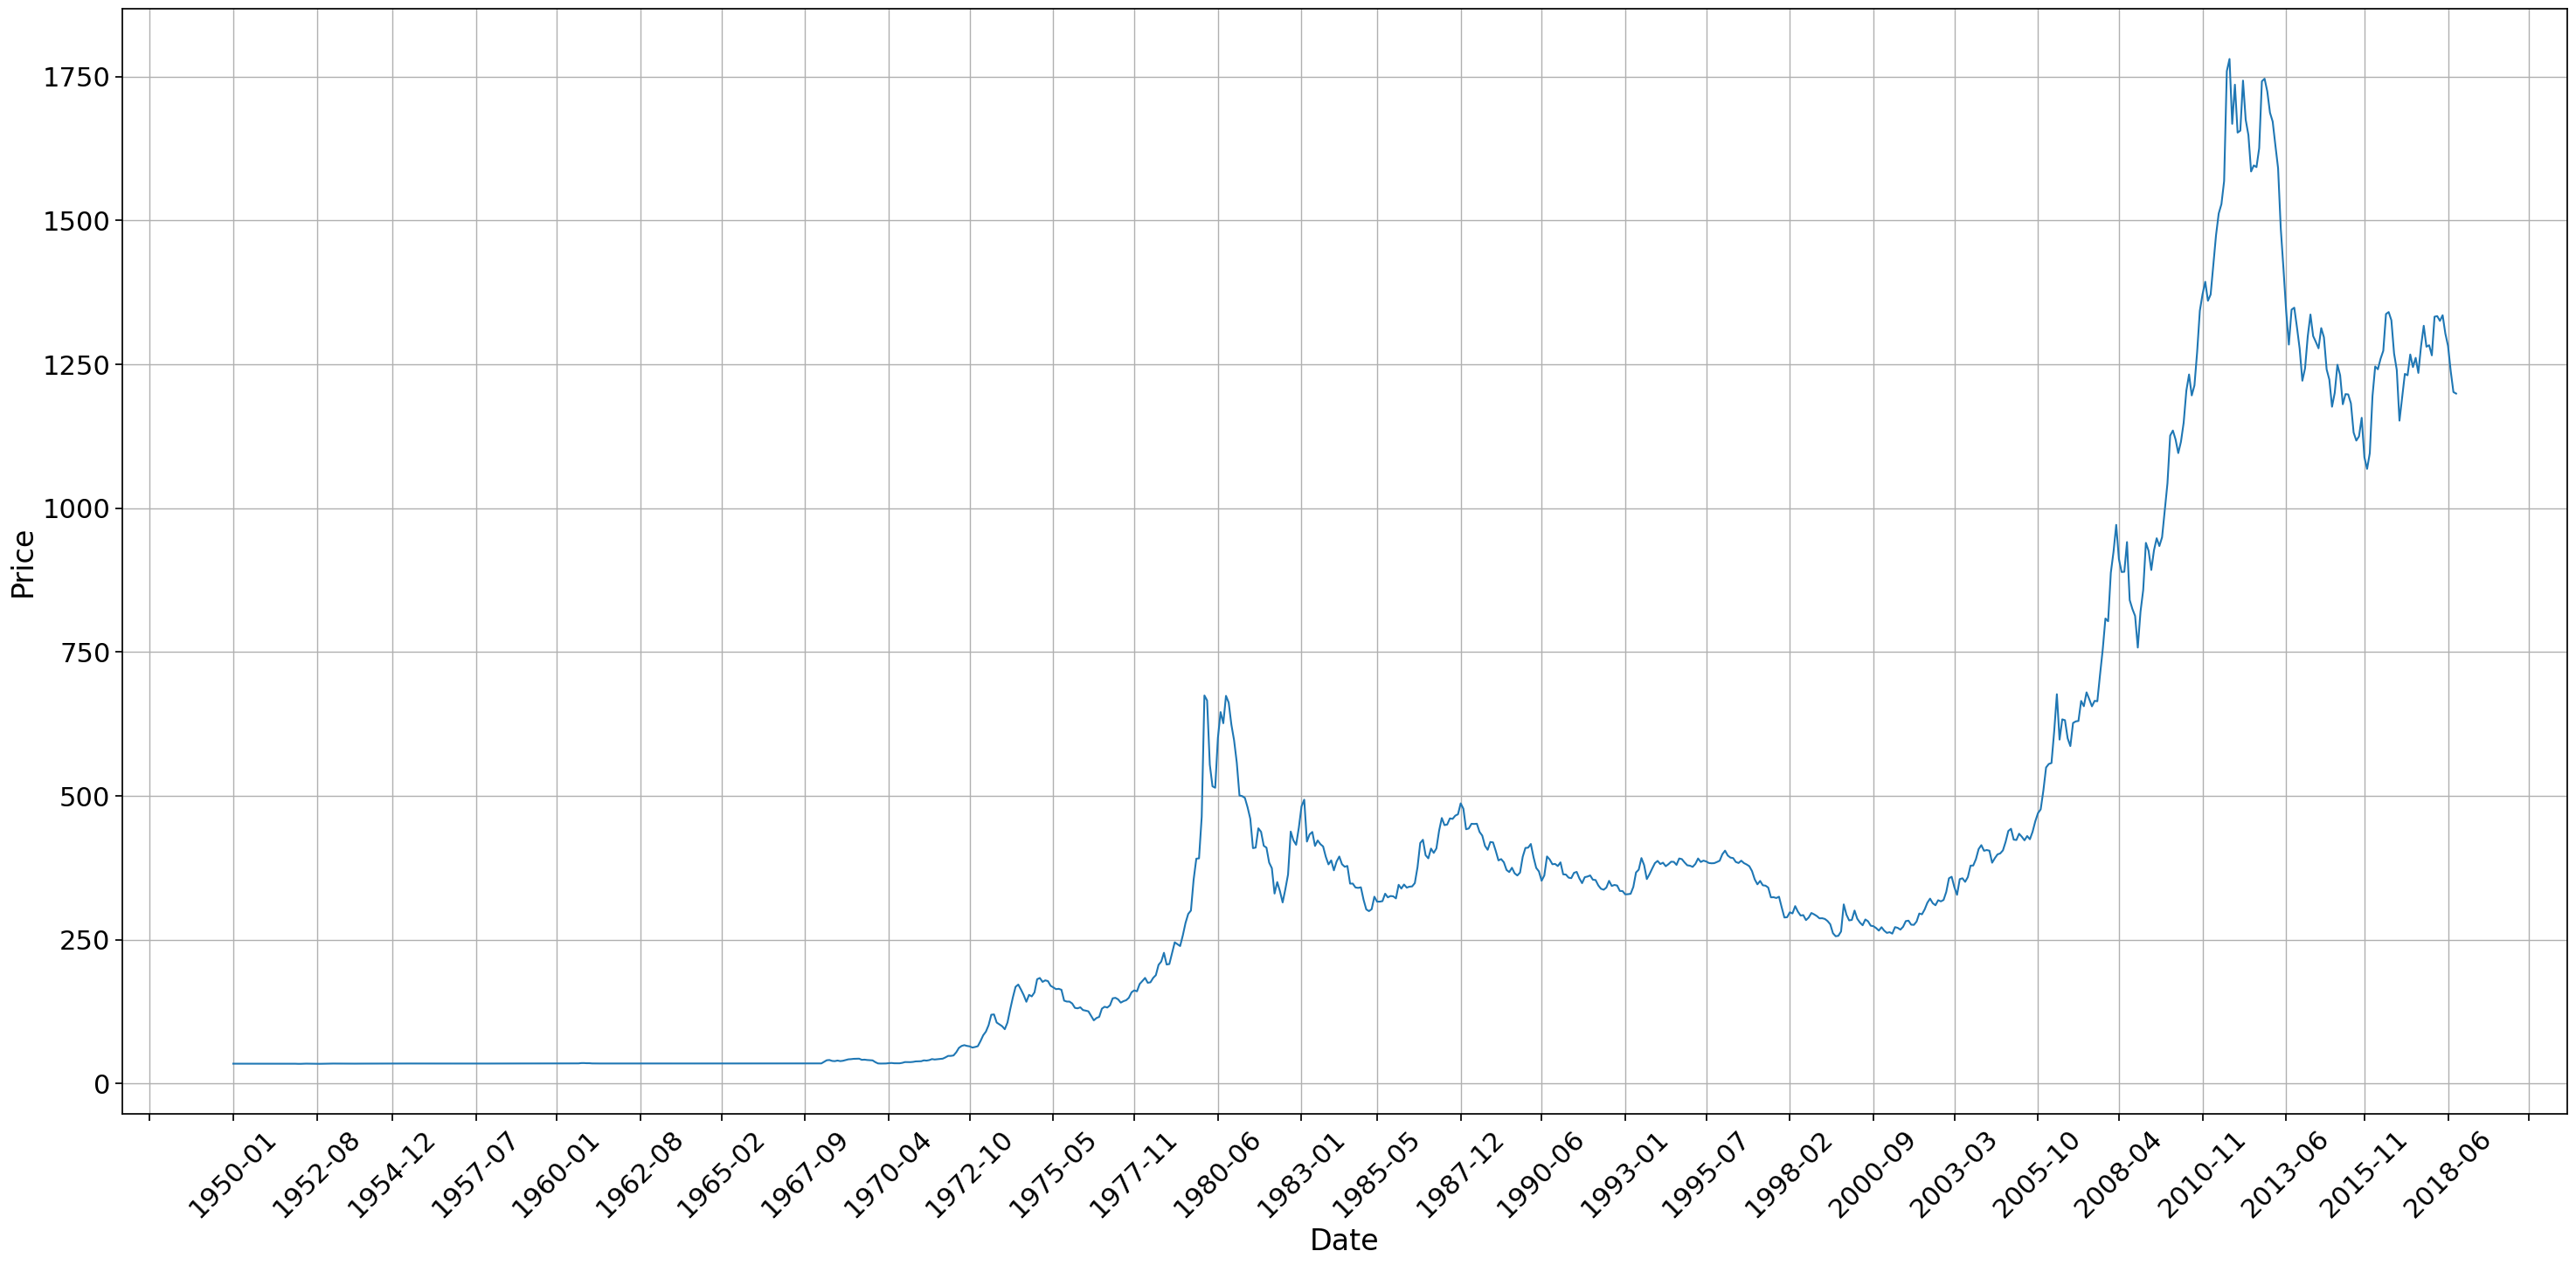

In [7]:
import matplotlib.dates as mdates


plt.figure(figsize=(30,15))
sns.set_context(context='notebook', font_scale=2)
sns.lineplot(x='Date', y='Price', data=df)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

> Catatan:
>
> - **1950 hingga 1970**: Harga-harga tetap relatif datar, menunjukkan stabilitas.
> - **1970 hingga 1980**: Lonjakan harga yang signifikan, kemungkinan disebabkan oleh peristiwa ekonomi (misalnya, penghapusan standar emas).
> - **1980 hingga 2000**: Tren menurun dan stabil, dengan fluktuasi kecil.
> - **2000 hingga 2011**: Kenaikan harga emas yang dramatis, mencapai titik tertinggi sepanjang sejarah pada tahun 2011.
> - **2011 hingga 2018**: Harga turun dan stabil dengan fluktuasi moderat, tetapi tetap lebih tinggi dibandingkan dengan dekade sebelumnya.

## **Modeling and Evaluation**

#### **Split Data**

In [8]:
df = df[df['Date']>'2003-01']
df_train=df[(df['Date']>'2006-01') & (df['Date']<='2013-05')]
df_test=df[df['Date']>'2013-05']

display(len(df_train),len(df_test))

88

64

> Catatan:
>
> - Dataset dibagi menjadi set pelatihan dan set pengujian untuk menghindari kebocoran data.
> - **Training Data**: Menggunakan data **7 tahun** terbaru karena perbedaan tren harga emas (kami ingin tren terbaru dan relevan untuk memperkirakan tren masa depan).
> - **Test Data**: Data **5 tahun terakhir** digunakan untuk evaluasi dan peramalan.

#### **ARIMA**

In [9]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

p = q = range(0, 10)
d = 1

pdq = [(x, d, y) for x, y in itertools.product(p, q)]

results = []

for param in pdq:
    try:
        model = ARIMA(df_train['Price'], order=param)

        model_fit = model.fit()

        forecast_steps = len(df_test)
        arima_forecast = model_fit.forecast(steps=forecast_steps)

        arima_rmse = mean_squared_error(df_test['Price'], arima_forecast, squared=False)

        results.append((param, arima_rmse))

    except Exception as e:
        continue

# Sort the results based on RMSE in descending order
sorted_results = sorted(results, key=lambda x: x[1], reverse=False)

sorted_results = pd.DataFrame(sorted_results).sort_values(1, ascending=True).rename({0:'order', 1:'rmse'}, axis=1)
sorted_results.head()

,order,rmse
0,"(6, 1, 9)",65.923997
1,"(8, 1, 3)",78.279552
2,"(3, 1, 3)",81.027171
3,"(1, 1, 5)",83.092184
4,"(3, 1, 2)",83.233815


> Catatan:
>
> - Model ARIMA disetel dengan melakukan **pencarian grid** pada nilai yang berbeda dari \( p \), \( d \), dan \( q \).
> - **Parameter Non-Musiman**:
> - \( p \): Jumlah pengamatan lag.
> - \( d \): Jumlah perbedaan yang diperlukan untuk membuat deret waktu menjadi stasioner (diatur ke 1 dalam kasus ini).
> - \( q \): Ukuran jendela rata-rata bergerak.
> - **Strategi Penyetelan**:
> - Pencarian grid pada kombinasi \( p \) dan \( q \) (mulai dari 0 hingga 9) dilakukan dengan \( d \) ditetapkan pada 1.
> - RMSE (Root Mean Squared Error) dihitung untuk setiap kombinasi, dan model dengan kinerja terbaik dipilih berdasarkan nilai RMSE terendah.
> - **Hasil**: Hasil disimpan, diurutkan, dan ditampilkan, sehingga urutan model ARIMA terbaik (dengan RMSE terendah) dapat dipilih untuk meramalkan tren masa depan.

In [10]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df_train['Price'],order=sorted_results.iloc[0]['order'])

model_fit=model.fit()

forecast_length=64
forecast_result=model_fit.forecast(forecast_length)

root_mean_squared_error(df_test['Price'], forecast_result)

65.92399701752464

In [11]:
month=list(df_test['Date'].unique())

df_forecast_arima=pd.DataFrame({'Date':month,'Price':forecast_result})
df_forecast_arima

,Date,Price
88,2013-06,1416.396150
89,2013-07,1421.221126
90,2013-08,1395.092543
91,2013-09,1375.580097
92,2013-10,1365.078480
...,...,...
147,2018-05,1229.303851
148,2018-06,1243.778251
149,2018-07,1250.233835
150,2018-08,1237.951593


In [12]:
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(name='Actual', x=df['Date'], y=df['Price'], mode='markers')])

fig.add_trace(go.Scatter(name='Forecast', x=df_forecast_arima['Date'], y=df_forecast_arima['Price']))
fig.show()

> Catatan:
>
> - **Strategi Penyetelan**: Kami menetapkan \( d = 1 \) (urutan pembedaan) dan melakukan pencarian grid pada nilai \( p \) dan \( q \) (kisaran 0 hingga 10) untuk menemukan model terbaik menggunakan RMSE (root mean squared error).
>
> - **Pemilihan Model Terbaik**: Model dengan RMSE terendah dipilih sebagai model ARIMA terbaik untuk peramalan dengan orde (6, 1, 9).
>
> - **Evaluasi**: Model ARIMA terpilih digunakan untuk meramalkan 64 bulan ke depan, dan keakuratannya dievaluasi dengan menggunakan RMSE pada data uji dengan nilai **65,9**.

#### **SARIMA**

In [13]:
import itertools

p = q = range(0, 5)
d = 1
P = Q = range(0, 2)
D = 1
s = 12

pdq = [(x, d, y) for x, y in itertools.product(p, q)]
seasonal_pdq = [(x, D, y, s) for x, y in itertools.product(P, Q)]

results = []

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(df_train['Price'], order=param, seasonal_order=seasonal_param)

            model_fit = model.fit(disp=False)

            forecast_steps = len(df_test)
            sarima_forecast = model_fit.forecast(steps=forecast_steps)

            sarima_rmse = mean_squared_error(df_test['Price'], sarima_forecast, squared=False)

            results.append((param, seasonal_param, sarima_rmse))

        except Exception as e:
            continue

# Convert the results to a DataFrame and sort based on RMSE in ascending order
sorted_results = pd.DataFrame(results, columns=['order', 'seasonal_order', 'rmse']).sort_values('rmse', ascending=True)

sorted_results.head()

,order,seasonal_order,rmse
6,"(0, 1, 1)","(1, 1, 0, 12)",191.513035
22,"(1, 1, 0)","(1, 1, 0, 12)",191.641958
2,"(0, 1, 0)","(1, 1, 0, 12)",192.352175
50,"(2, 1, 2)","(1, 1, 0, 12)",194.660771
54,"(2, 1, 3)","(1, 1, 0, 12)",194.888020


> Catatan:
>
> - **Penyiapan Model**: SARIMA memperluas ARIMA dengan memasukkan parameter non-musiman \((p, d, q) \) dan parameter musiman \((P, D, Q, s) \) untuk menangkap pola musiman. Kami menggunakan pencarian grid untuk menguji berbagai kombinasi parameter ini.
>
> - **Evaluasi**: Setiap kombinasi parameter dievaluasi menggunakan **RMSE** pada data uji. Model dengan RMSE terendah dipilih sebagai model dengan kinerja terbaik.
>
> - **Perbedaan Utama dari ARIMA**: Tidak seperti ARIMA, SARIMA memperhitungkan **musiman** dengan menambahkan istilah musiman \((P, D, Q, s) \), yang membantu memodelkan pola siklus yang berulang dalam periode yang tetap (seperti tren bulanan).

In [14]:
model=SARIMAX(df_train['Price'],order=sorted_results.iloc[0]['order'], seasonal_order=sorted_results.iloc[0]['seasonal_order'])

model_fit=model.fit()

forecast_length=64
forecast_result=model_fit.forecast(forecast_length)

root_mean_squared_error(df_test['Price'], forecast_result)

191.51303460596344

In [15]:
month=list(df_test['Date'].unique())

df_forecast_sarima=pd.DataFrame({'Date':month,'Price':forecast_result})
df_forecast_sarima

,Date,Price
88,2013-06,1423.028475
89,2013-07,1442.197902
90,2013-08,1556.047353
91,2013-09,1623.591763
92,2013-10,1568.007367
...,...,...
147,2018-05,986.491048
148,2018-06,994.650080
149,2018-07,1006.100236
150,2018-08,1091.568256


In [16]:
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(name='Actual', x=df['Date'], y=df['Price'], mode='markers')])

fig.add_trace(go.Scatter(name='Forecast', x=df_forecast_sarima['Date'], y=df_forecast_sarima['Price']))
fig.show()

> Catatan:
>
> - **Strategi Penyetelan**: Kami menetapkan \( d = 1 \) (urutan differencing) dan melakukan pencarian grid pada nilai \( p \) dan \( q \) (kisaran 0 hingga 5) untuk menemukan model terbaik menggunakan RMSE (root mean squared error).
>
> - **Pemilihan Model Terbaik**: Model dengan RMSE terendah dipilih sebagai model ARIMA terbaik untuk peramalan dengan orde (0, 1, 1) dengan orde musiman (1, 1, 0, 12).
>
> - **Evaluasi**: Model ARIMA yang dipilih digunakan untuk meramalkan 64 bulan ke depan, dan akurasinya dievaluasi dengan menggunakan RMSE pada data uji dengan skor **191,5**. Secara keseluruhan, skor ini dan yang ditunjukkan pada diagram garis di atas berkinerja lebih buruk daripada ARIMA dasar.

#### **Prophet**

In [17]:
import random

df_train_prophet = df_train.rename(columns={'Date': 'ds', 'Price': 'y'})
df_test_prophet = df_test.rename(columns={'Date': 'ds', 'Price': 'y'})

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0, 2.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0, 20.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [True, False],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Sample a random subset of the combinations (e.g., 20 random combinations)
random.seed(42)
sampled_params = random.sample(all_params, min(len(all_params), 100))  # Adjust sample size as needed

results = []

for params in sampled_params:
    try:
        prophet_model = Prophet(**params)
        prophet_model.fit(df_train_prophet)

        future = prophet_model.make_future_dataframe(periods=len(df_test), freq='D')

        prophet_forecast = prophet_model.predict(future)
        prophet_forecast_test = prophet_forecast[-len(df_test):]

        prophet_rmse = mean_squared_error(df_test_prophet['y'], prophet_forecast_test['yhat'], squared=False)

        results.append((params, prophet_rmse))
    except Exception as e:
        continue

sorted_results = sorted(results, key=lambda x: x[1])

sorted_results_df = pd.DataFrame(sorted_results, columns=['params', 'rmse'])

sorted_results_df.head()

08:34:31 - cmdstanpy - INFO - Chain [1] start processing
08:34:32 - cmdstanpy - INFO - Chain [1] done processing
08:34:32 - cmdstanpy - INFO - Chain [1] start processing
08:34:33 - cmdstanpy - INFO - Chain [1] done processing
08:34:33 - cmdstanpy - INFO - Chain [1] start processing
08:34:33 - cmdstanpy - INFO - Chain [1] done processing
08:34:34 - cmdstanpy - INFO - Chain [1] start processing
08:34:35 - cmdstanpy - INFO - Chain [1] done processing
08:34:35 - cmdstanpy - INFO - Chain [1] start processing
08:34:36 - cmdstanpy - INFO - Chain [1] done processing
08:34:36 - cmdstanpy - INFO - Chain [1] start processing
08:34:37 - cmdstanpy - INFO - Chain [1] done processing
08:34:37 - cmdstanpy - INFO - Chain [1] start processing
08:34:38 - cmdstanpy - INFO - Chain [1] done processing
08:34:38 - cmdstanpy - INFO - Chain [1] start processing
08:34:39 - cmdstanpy - INFO - Chain [1] done processing
08:34:39 - cmdstanpy - INFO - Chain [1] start processing
08:34:40 - cmdstanpy - INFO - Chain [1]

> Catatan:
>
> - **Bagaimana Prophet Bekerja**: Prophet menguraikan deret waktu menjadi tren, musiman, dan hari libur, secara otomatis mendeteksi pergeseran tren dan pola musiman tanpa transformasi manual.
>
> - **Perbedaan Utama dari ARIMA/SARIMA**: Prophet dapat menangani data non-stasioner dan tidak memerlukan pembedaan seperti ARIMA/SARIMA. Prophet secara langsung memodelkan tren dan musiman, sementara ARIMA/SARIMA berfokus pada autoregressive dan moving average.
>
> - **Penjelasan setiap hyperparam**:
> - **`changepoint_prior_scale`**: Mengontrol fleksibilitas tren. Nilai yang lebih tinggi memungkinkan tren untuk beradaptasi lebih cepat terhadap perubahan, sementara nilai yang lebih rendah membuat tren lebih halus.
>
> - **`seasonality_prior_scale`**: Mengatur fleksibilitas komponen musiman. Nilai yang lebih tinggi memungkinkan lebih banyak variasi dalam musiman, sementara nilai yang lebih rendah membuat pola musiman lebih stabil.
>
> - **`holidays_prior_scale`**: Mengontrol fleksibilitas efek hari libur. Nilai yang lebih tinggi memungkinkan efek hari libur lebih bervariasi, sementara nilai yang lebih rendah membuat efek hari libur lebih dibatasi.
>
> - **`seasonality_mode`**: Menentukan apakah musiman bersifat **additive** (menambah tren) atau **multiplicative** (bervariasi secara proporsional dengan tren).
>
> - **`musiman_tahunan`**: Mengaktifkan atau menonaktifkan musiman tahunan dalam model.
>
> - **`musiman_mingguan`**: Mengaktifkan atau menonaktifkan musiman mingguan dalam model.
>
> - **`musiman_harian`**: Mengaktifkan atau menonaktifkan musiman harian dalam model.

In [ ]:
best_params = sorted_results_df.iloc[0]['params']

prophet_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    yearly_seasonality=best_params['yearly_seasonality'],
    weekly_seasonality=best_params['weekly_seasonality'],
    daily_seasonality=best_params['daily_seasonality']
)

prophet_model.fit(df_train_prophet)

future = prophet_model.make_future_dataframe(periods=len(df_test), freq='D')

prophet_forecast = prophet_model.predict(future)
prophet_forecast_test = prophet_forecast[-len(df_test):]['yhat']

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj4se_zr/w42ex7nk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbj4se_zr/uu681f3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25013', 'data', 'file=/tmp/tmpbj4se_zr/w42ex7nk.json', 'init=/tmp/tmpbj4se_zr/uu681f3b.json', 'output', 'file=/tmp/tmpbj4se_zr/prophet_modelrfhe77oj/prophet_model-20240926085827.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:58:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:58:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
month=list(df_test['Date'].unique())

df_forecast_prophet=pd.DataFrame({'Date':month,'Price':prophet_forecast_test})
df_forecast_prophet

,Date,Price
88,2013-06,1478.478790
89,2013-07,1455.082304
90,2013-08,1415.246190
91,2013-09,1377.064324
92,2013-10,1343.402126
...,...,...
147,2018-05,1493.805741
148,2018-06,1555.894578
149,2018-07,1635.248505
150,2018-08,1680.407024


In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(name='Actual', x=df['Date'], y=df['Price'], mode='markers')])

fig.add_trace(go.Scatter(name='Forecast', x=df_forecast_prophet['Date'], y=df_forecast_prophet['Price']))
fig.show()

> Catatan:
>
> - **Strategi Penyetelan**: Kami melakukan pencarian grid di berbagai hiperparameter Prophet termasuk `changepoint_prior_scale`, `seasonality_prior_scale`, dan `holidays_prior_scale`, dengan menguji 100 kombinasi acak untuk menemukan model terbaik dengan menggunakan RMSE (root mean squared error).
>
> - **Pemilihan Model Terbaik**: Model dengan RMSE terendah dipilih sebagai model Prophet terbaik untuk peramalan, dengan parameter seperti `changepoint_prior_scale` diatur ke 2,5 dan `seasonality_prior_scale` diatur ke 20,0.
>
> - **Evaluasi**: Model Prophet yang dipilih digunakan untuk meramalkan nilai masa depan, dan akurasinya dievaluasi dengan menggunakan RMSE pada data uji. Performa model divisualisasikan dan dibandingkan dengan metode lain, memberikan wawasan tentang tren dan efek musiman. Secara keseluruhan, model ini menunjukkan kinerja yang buruk dan tidak dapat menangkap tren utama.

#### **Model Comparison**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(name='Actual', x=df['Date'], y=df['Price'], mode='markers')])

fig.add_trace(go.Scatter(name='Prophet', x=df_forecast_prophet['Date'], y=df_forecast_prophet['Price']))
fig.add_trace(go.Scatter(name='ARIMA', x=df_forecast_arima['Date'], y=df_forecast_arima['Price']))
fig.add_trace(go.Scatter(name='SARIMA', x=df_forecast_sarima['Date'], y=df_forecast_sarima['Price']))
fig.show()

> Catatan:
>
> - **Kinerja Prakiraan**: Model **Prophet** menangkap tren awal tetapi gagal menangkap tren jangka panjang dan terlalu tinggi memperkirakan nilai masa depan, terutama setelah tahun 2015, sehingga menunjukkan kinerja yang buruk di periode selanjutnya.
>
> - **SARIMA**: Model ini berkinerja buruk dan menciptakan pola yang konstan sepanjang prediksi. Model ini gagal menangkap tren apa pun.
>
> - **Model Berkinerja Terbaik**: Secara keseluruhan, **ARIMA** menunjukkan kecocokan yang lebih baik pada periode pengujian, memiliki RMSE paling kecil di sekitar **65,9**, dan dapat menangkap tren dengan baik dari waktu ke waktu.

#### **Final Result Forcast**

In [ ]:
# Concatenating train and test DataFrames along the rows
df_final = pd.concat([df_train, df_test])
df_final = df_final[["Date","Price"]]
df_final

,Date,Price
673,2006-02,555.518
674,2006-03,557.215
675,2006-04,611.853
676,2006-05,676.769
677,2006-06,597.898
...,...,...
820,2018-05,1303.618
821,2018-06,1282.126
822,2018-07,1238.064
823,2018-08,1201.859


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df_final['Price'],order=(6,1,9))

model_fit=model.fit()

forecast_length=24
forecast_result=model_fit.forecast(forecast_length)

> Catatan:
>
> - **Prediksi**: Kami akan memilih model dengan performa terbaik dari ketiganya (Tuned ARIMA) dan meramalkan 2 tahun ke depan.

In [ ]:
import pandas as pd

last_date = pd.to_datetime(df_test['Date'].max())

month = pd.date_range(last_date + pd.DateOffset(months=1), periods=24, freq='M').strftime('%Y-%m').tolist()

df_forecast_final = pd.DataFrame({'Date': month, 'Price': forecast_result})
df_forecast_final.head()

,Date,Price
152,2018-10,1183.045524
153,2018-11,1171.640052
154,2018-12,1169.644143
155,2019-01,1177.909550
156,2019-02,1199.004246


In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(name='Actual', x=df_final['Date'], y=df_final['Price'], mode='markers')])

fig.add_trace(go.Scatter(name='Forecast', x=df_forecast_final['Date'], y=df_forecast_final['Price']))
fig.show()

> Catatan:
>
> - **Final Forecast Performance**: Lineplot akhir di atas menunjukkan prediksi 2 tahun ke depan untuk harga emas berdasarkan hasil pelatihan model ARIMA yang telah disetel. Ini menunjukkan tren penurunan harga emas.

## **Conclusion & Recommendation**

### **Conclusion**
Di antara ketiga model (ARIMA, SARIMA, dan Prophet), model ARIMA memberikan performa terbaik dengan RMSE 65,9, menjadikannya model yang paling akurat untuk meramalkan harga emas di masa depan. Model ini dapat menangkap perubahan tren dari waktu ke waktu secara signifikan sehingga dapat meramalkan harga dengan akurasi yang lebih tinggi.

### **Recommendation**
Perusahaan sebaiknya menggunakan model ARIMA untuk memprediksi harga emas karena akurasinya yang superior. Untuk perbaikan yang berkelanjutan, disarankan untuk melakukan penyetelan dan pemantauan lebih lanjut terhadap performa model dalam merespons perubahan kondisi pasar.